In [1]:
"""
Erlang C queue with working holidays
Cloned from https://github.com/mhicoayala/erlang_c, re-written from scratch

Main assumptions:

1. Vacation arrival rate would be bigger than the normal vacation rate due to this might happen
during weekends
2. The Number of agents would be lower, for obvious reasons
3. The same goes for service rate.

Note: All of this needs to be run at the same time because this is literally a 'copy-pasted' script from main.py
"""

import math
import matplotlib.pyplot as plt

In [2]:
# We modify the code a little to include Working Vacation
# Since the implementation is just put everything into a bernoulli term, yeah
normal_arrival_rate = 2250
vacation_arrival_rate = 3750
normal_num_agents = 7
vacation_num_agents = 2
normal_service_rate = 45
vacation_service_rate = 25

# Vacation probability
vac_prob = 0.5

# Misc variables
average_handling_time = 180  # Seconds
target_answer_time = 20  # Seconds
target_sla = 0.80
shrinkage = 0.30

In [161]:
def get_traffic_intensity(arrival_rate, num_agents, service_rate):

    # This function calculates the traffic intensity (or A) for Erlang C
    # Need to be put outside since we're dealing with 2 different values and we don't want to mix
    # everything up into one.

    return arrival_rate / (num_agents * service_rate)


traffic_n = get_traffic_intensity(
    normal_arrival_rate, normal_num_agents, normal_service_rate
)
traffic_v = get_traffic_intensity(
    vacation_arrival_rate, vacation_num_agents, vacation_service_rate
)

# Combined traffic
traffic = (vac_prob * traffic_v) + ((1 - vac_prob) * traffic_n)

In [162]:
# Erlang C queue model
class ErlangQueue:

    # I put everything in a class to make it more simple
    # We need to calculate the intensity outside to make it more simple

    def __init__(
        self,
        num_agents,
        target_answer_time,
        target_service_level_agreement,
        average_handling_time,
        shrinkage,
    ):

        self.num_agents = num_agents
        self.target_answer_time = target_answer_time
        self.target_service_level_agreement = target_service_level_agreement
        self.average_handling_time = average_handling_time
        self.shrinkage = shrinkage

    def waiting_probability(self, traffic_intensity):

        # Calculating the waiting probability

        x = (
            (
                (traffic_intensity**self.num_agents)
                / math.factorial(round(self.num_agents))
            )
            * self.num_agents
            / (self.num_agents - traffic_intensity)
        )
        y = 1

        for i in range(round(self.num_agents)):
            y += (traffic_intensity**i) / math.factorial(i)

        return x / (y + x)

    def service_level_agreement(self, wait_prob, traffic_intensity):

        # Calculating the service level agreement

        return 1 - (
            wait_prob
            * (
                math.e
                ** -(
                    (self.num_agents - traffic_intensity)
                    * (self.target_answer_time / self.average_handling_time)
                )
            )
        )

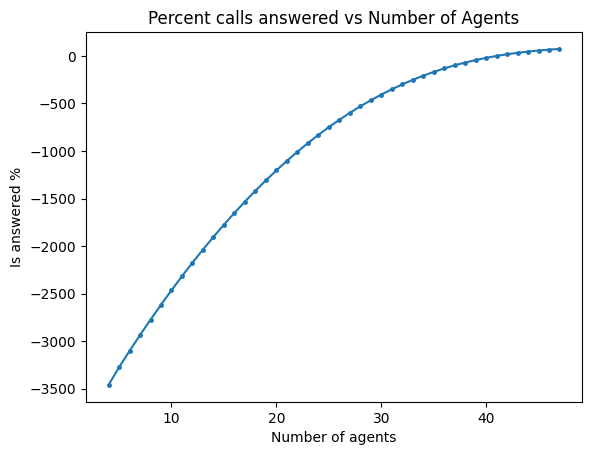

In [163]:
def forward(
    traffic_intensity,
    num_agents,
    target_answer_time,
    target_service_level_agreement,
    average_handling_time,
    shrinkage,
):

    # For plotting purposes
    wp_list = list()
    sla_list = list()
    agent_list = list()
    average_answer_speed = list()
    percent_calls_answered_immediately = list()
    maximum_occupancy = list()
    num_shrinkage = list()

    # On the original implementation, the number of agents is determined by rounding the traffic
    # intensity and added it by 1. However, since we're dealing with a case, it would be the best
    # for us to use proper num_agents instead.

    # This will be counted outside the function.

    queue = ErlangQueue(
        num_agents,
        target_answer_time,
        target_service_level_agreement,
        average_handling_time,
        shrinkage,
    )

    wp = queue.waiting_probability(traffic_intensity)
    wp_list.append(wp)
    sla = queue.service_level_agreement(wp, traffic_intensity)
    sla_list.append(round((sla * 100), 2))
    agent_list.append(num_agents)

    average_answer_speed.append(
        round(((wp * average_handling_time) / (num_agents - traffic_intensity)), 1)
    )
    percent_calls_answered_immediately.append(round(((1 - wp) * 100), 2))
    maximum_occupancy.append(round(((traffic_intensity / num_agents) * 100), 2))
    num_shrinkage.append(math.ceil(num_agents / (1 - shrinkage)))

    # Optimization
    while sla < target_service_level_agreement:
        num_agents += 1
        queue = ErlangQueue(
            num_agents,
            target_answer_time,
            target_service_level_agreement,
            average_handling_time,
            shrinkage,
        )

        wp = queue.waiting_probability(traffic_intensity)
        wp_list.append(wp)
        sla = queue.service_level_agreement(wp, traffic_intensity)
        sla_list.append(round((sla * 100), 2))
        agent_list.append(num_agents)

        average_answer_speed.append(
            round(((wp * average_handling_time) / (num_agents - traffic_intensity)), 1)
        )
        percent_calls_answered_immediately.append(round(((1 - wp) * 100), 2))
        maximum_occupancy.append(round(((traffic_intensity / num_agents) * 100), 2))
        num_shrinkage.append(math.ceil(num_agents / (1 - shrinkage)))

    return (
        wp_list,
        sla_list,
        agent_list,
        average_answer_speed,
        percent_calls_answered_immediately,
        maximum_occupancy,
        num_shrinkage,
    )


# The real deal

# To determine the number of agents, we do the same thing with how we combine both traffic intensities. This
# essentially combines both while emphasizing on the probability.
num_agents = round(
    ((vac_prob * vacation_num_agents) + ((1 - vac_prob) * normal_num_agents))
)

(
    wp_list,
    sla_list,
    final_num_agents,
    average_answer_speed,
    percent_calls_answered,
    max_occupancy,
    shrinkage,
) = forward(
    traffic,
    num_agents,
    target_answer_time,
    target_sla,
    average_handling_time,
    shrinkage,
)

# wp_list_wv = [None, None, None, 3.36954580016479, 2.1690891398833063, 1.4150446018024927, 0.8906694235848065, 0.5336470865429626, 0.3023644145832225, 0.16133964663618938]
# Plotting the probability of waiting and SLA w.r.t to the amount of agents
plt.title("Percent calls answered vs Number of Agents")
plt.plot(final_num_agents,
         percent_calls_answered,
         marker=".",
         markersize=5)  # Waiting probability wrt to number of people
plt.xlabel("Number of agents")
plt.ylabel("Is answered %")
# plt.plot(final_num_agents, sla_list, 'r')  # SLA wrt number of people
# plt.plot(final_num_agents, average_answer_speed, 'r')  # Answer speed wrt number of people
# plt.plot(final_num_agents, percent_calls_answered, 'r')  # Percent call answered wrt number of people
# plt.plot(final_num_agents, max_occupancy, 'r')  # Max occupancy wrt number of people
# plt.plot(final_num_agents, shrinkage, "r")  # Shrinkage wrt number of people
plt.savefig("wpvsn.png")
plt.show()